# Good Sleep and Next Day RHR

**“Nights with ≥7 h sleep yield a lower next-day resting heart rate than nights with <6 h.”**

# Introduction

For this project, we wanted to test a simple and very common idea:
**Does getting more sleep make your resting heart rate lower the next day?**

A lower resting heart rate (RHR) usually means your body is more relaxed and recovered. So if sleep really helps recovery, then nights with more sleep should show a lower RHR the following day.

To check this, we used Fitbit data from real people. The dataset includes two important types of information:

---

## 1. Sleep Data (minute-by-minute sleep)

This tells us:

* When a person fell asleep
* When they woke up
* How many total minutes they slept
* Which “sleep group” they belong to

  * **< 6 hours**
  * **6–7 hours**
  * **≥ 7 hours**

**How we calculated sleep hours:**
We combined all the sleep minutes for each night, converted them into hours, and grouped people based on how long they slept.

**Why we need this:**
Sleep duration is our **independent variable** — the thing we want to compare against resting heart rate.

---

## 2. Heart Rate Data (second-by-second)

The heart rate dataset records a person’s heart rate every second of the day. Instead of searching for one perfect “morning” reading, we used a smarter method.

**How we estimated resting heart rate:**
For each day, we looked at all the heart rate values during the 24 hours after waking up.
We then took a **low percentile** (like the 15th percentile). This gives us a good estimate of when the person was most relaxed—basically their “resting-like” heart rate for that day.

This becomes our **dependent variable** — the measurement we think might change based on sleep.

---

## What We Are Testing (The Hypothesis)

**Hypothesis:**
*Nights with at least 7 hours of sleep will have a lower next-day resting heart rate compared to nights with less than 6 hours of sleep.*

To test this, we:

1. Calculated each person's sleep hours for each night
2. Estimated their resting heart rate for the following day
3. Grouped the results by sleep duration
4. Compared the RHR values between the groups
5. Ran a simple statistical test to see if the differences were real or just random



## Load the Data

### 1) Sleep minutes (minute-by-minute sleep)

In [44]:
# Block 1 — Load sleep data from both time periods

import pandas as pd
from pathlib import Path

# This is the folder where all the data files are stored
data_folder = Path("data")

# These are the two sleep files we want to use (March–April and April–May)
sleep_file_march_april = data_folder / "mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteSleep_merged.csv"
sleep_file_april_may   = data_folder / "mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteSleep_merged.csv"

# Read (open) both files into two tables
sleep_part1 = pd.read_csv(sleep_file_march_april)
sleep_part2 = pd.read_csv(sleep_file_april_may)

# Combine the two tables into one big table
sleep_minutes_df = pd.concat([sleep_part1, sleep_part2], ignore_index=True)

# Turn the "date" column into a real date so Python understands it as a time
sleep_minutes_df["date"] = pd.to_datetime(sleep_minutes_df["date"])

# Sort the data so it is in order: first by person, then by time
sleep_minutes_df = sleep_minutes_df.sort_values(["Id", "date"]).reset_index(drop=True)

# Print how many rows we have
print("sleep_minutes_df rows:", len(sleep_minutes_df))

# Show information about the table: columns, data types, etc.
sleep_minutes_df.info()


sleep_minutes_df rows: 387080
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387080 entries, 0 to 387079
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Id      387080 non-null  int64         
 1   date    387080 non-null  datetime64[ns]
 2   value   387080 non-null  int64         
 3   logId   387080 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 11.8 MB


### 2) Heart rate (second-by-second)

In [45]:
# Block 2 — Load heart rate data from both time periods

import pandas as pd
from pathlib import Path

# This is the folder where all the data files are stored
data_folder = Path("data")

# These are the two heart rate files (March–April and April–May)
hr_file_march_april = data_folder / "mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv"
hr_file_april_may   = data_folder / "mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv"

# Read (open) both files into two tables
hr_part1 = pd.read_csv(hr_file_march_april)
hr_part2 = pd.read_csv(hr_file_april_may)

# Combine the two tables into one big table
heart_rate_seconds_df = pd.concat([hr_part1, hr_part2], ignore_index=True)

# Change the 'Time' column into a real date+time so Python understands it
heart_rate_seconds_df["Time"] = pd.to_datetime(heart_rate_seconds_df["Time"])

# Sort all the heart rate data by person and by time
heart_rate_seconds_df = heart_rate_seconds_df.sort_values(["Id", "Time"]).reset_index(drop=True)

# Print how many total rows we now have
print("heart_rate_seconds_df rows:", len(heart_rate_seconds_df))

# Show details about the table (columns, data types, etc.)
heart_rate_seconds_df.info()


heart_rate_seconds_df rows: 3638339
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3638339 entries, 0 to 3638338
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Id      int64         
 1   Time    datetime64[ns]
 2   Value   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 83.3 MB


### Step 3 — Build a daily sleep summary  

We want one row per person per “main sleep,” giving:

| id | date | sleep_hours | sleep_group | wake_time |

So from `sleep_minutes_df`, we need to:

1. Group consecutive minutes belonging to the same `logId` (you already have `logId` in your data).
2. For each `logId`, compute:

   * `start_time` = min(`date`)
   * `wake_time` = max(`date`)
   * `sleep_minutes` = count of rows (`value == 1`)
3. Compute `sleep_hours = sleep_minutes / 60`
4. Then, per `Id` and `wake_day = wake_time.date()`, **keep only the longest sleep period** (that’s the main sleep of that day).
5. Add a `sleep_group` label (`<6h`, `6–7h`, `≥7h`).


In [46]:
# Step 3 — Build daily sleep summary
import pandas as pd

# Group by person and logId to get each sleep session
sleep_sessions = (
    sleep_minutes_df.groupby(['Id', 'logId'])
    .agg(
        start_time=('date', 'min'),
        wake_time=('date', 'max'),
        sleep_minutes=('value', 'count')
    )
    .reset_index()
)

# Calculate hours slept
sleep_sessions['sleep_hours'] = sleep_sessions['sleep_minutes'] / 60

# Create "wake_day" (calendar day when they woke up)
sleep_sessions['wake_day'] = sleep_sessions['wake_time'].dt.date

# For each person and day, keep the longest sleep session (main sleep)
main_sleep = (
    sleep_sessions.sort_values(['Id', 'wake_day', 'sleep_minutes'], ascending=[True, True, False])
    .groupby(['Id', 'wake_day'])
    .head(1)
    .reset_index(drop=True)
)

# Add sleep_group column
def classify_sleep(hours):
    if hours < 6:
        return "<6h"
    elif hours < 7:
        return "6–7h"
    else:
        return "≥7h"

main_sleep['sleep_group'] = main_sleep['sleep_hours'].apply(classify_sleep)

# Rename columns to match target structure
daily_sleep_df = main_sleep.rename(columns={'wake_day': 'date', 'Id': 'id'})

print("daily_sleep_df shape:", daily_sleep_df.shape)

daily_sleep_df shape: (832, 8)


In [47]:
daily_sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             832 non-null    int64         
 1   logId          832 non-null    int64         
 2   start_time     832 non-null    datetime64[ns]
 3   wake_time      832 non-null    datetime64[ns]
 4   sleep_minutes  832 non-null    int64         
 5   sleep_hours    832 non-null    float64       
 6   date           832 non-null    object        
 7   sleep_group    832 non-null    object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 52.1+ KB


## ✅ What This Table Shows

The table `daily_sleep_df` has **832 rows**.
Each row represents **one person’s main sleep for one day**.

So:
**832 sleep events (one per person per night).**

---

## 📌 What Each Column Means

**1. `id`** (number)
The person’s unique identifier.
No missing data — good.

**2. `logId`** (number)
The specific “sleep session” Fitbit recorded.

**3. `start_time`** (date/time)
When the person fell asleep.
No missing values.

**4. `wake_time`** (date/time)
When they woke up.
Also fully complete.

**5. `sleep_minutes`** (number)
How many minutes they slept.

**6. `sleep_hours`** (decimal number)
Same thing but in hours (sleep_minutes ÷ 60).

**7. `date`** (object/string)
The calendar date of wake-up.
This should ideally be stored as a real date, but it’s fine.

**8. `sleep_group`** (text)
A label showing how much they slept:

* `<6h`
* `6–7h`
* `≥7h`

No missing values — good.

---

## 🎯 Quick, Simple Conclusions

* **The dataset is complete** — no missing values in any column.
* **Datetime columns are correctly stored** (`start_time`, `wake_time`).
* **You successfully built a clean “daily sleep summary”** with the expected features.
* **The table is ready to be merged** with heart-rate data for the next steps (computing resting heart rate).
* **The `date` column is a string**. That’s not wrong, but you *might* want to convert it to a date type later if needed.

/var/folders/v7/9q0s4zfd7r784wb6v6y_1lh00000gn/T/ipykernel_77954/1946023154.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


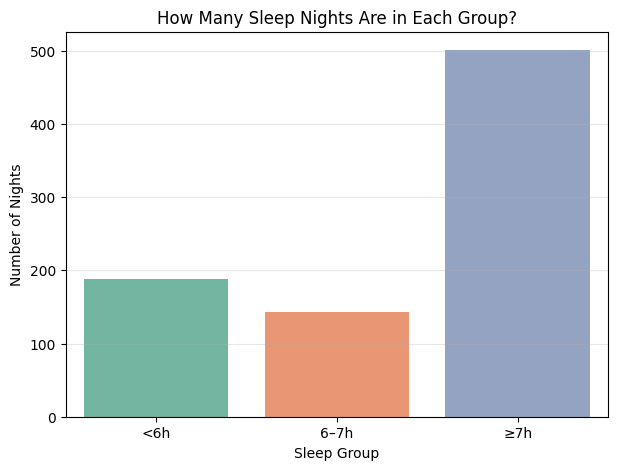

In [48]:
# Visual 1 — Bar chart of how many nights are in each sleep group
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.countplot(
    data=daily_sleep_df,
    x="sleep_group",
    order=["<6h", "6–7h", "≥7h"],
    palette="Set2"
)

plt.title("How Many Sleep Nights Are in Each Group?")
plt.xlabel("Sleep Group")
plt.ylabel("Number of Nights")
plt.grid(axis='y', alpha=0.3)

# ⬇️ Save the image locally
plt.savefig("GHNDRHR_visual1_sleep_group_counts.png", dpi=300, bbox_inches="tight")

plt.show()


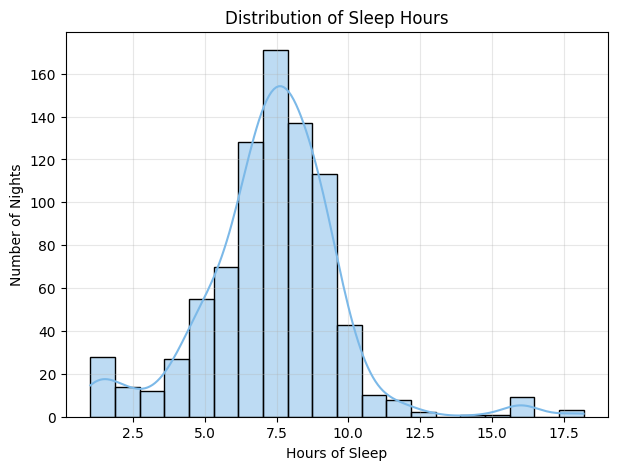

In [49]:
# Visual 2 — Histogram of sleep_hours
plt.figure(figsize=(7,5))
sns.histplot(
    data=daily_sleep_df,
    x="sleep_hours",
    bins=20,
    kde=True,
    color="#7CB9E8"
)

plt.title("Distribution of Sleep Hours")
plt.xlabel("Hours of Sleep")
plt.ylabel("Number of Nights")
plt.grid(True, alpha=0.3)

# ⬇️ Save the image locally
plt.savefig("GHNDRHR_visual2_distribution_of_sleep_hours.png", dpi=300, bbox_inches="tight")

plt.show()


### **Step 4 — Compute approximated resting heart rate**

We’ll look at all heart-rate values for the **24 hours after `wake_time`** for each `(id, date)` pair and take the **15th percentile**.
That gives us the `approximated_rhr`.

In [50]:
# Step 4 — Compute approximated resting heart rate (relaxed thresholds)

import numpy as np

def compute_approximated_rhr(row):
    # Get the person's ID
    person_id = row['id']

    # The time they woke up
    start = row['wake_time']

    # We will look at heart-rate data for 12 hours after waking up
    end = start + pd.Timedelta(hours=12)

    # Grab all heart-rate values for this person between wake_time and wake_time+12h
    hr_data = heart_rate_seconds_df[
        (heart_rate_seconds_df['Id'] == person_id) &
        (heart_rate_seconds_df['Time'] >= start) &
        (heart_rate_seconds_df['Time'] < end)
    ]['Value']

    # If there are too few readings, we cannot trust the result
    if len(hr_data) < 20:   # minimum ~20 readings
        return np.nan       # return "missing value"

    # Find the 15th percentile (a good estimate of resting-like heart rate)
    rhr = np.percentile(hr_data, 15)

    # Remove impossible or clearly bad values
    if rhr < 30 or rhr > 130:
        return np.nan

    # If everything looks good, return the estimated resting heart rate
    return rhr

# Apply the function to every row of daily_sleep_df
daily_sleep_df['approximated_rhr'] = daily_sleep_df.apply(compute_approximated_rhr, axis=1)

# Remove any rows where we couldn't calculate a good RHR
daily_sleep_df = daily_sleep_df.dropna(subset=['approximated_rhr'])

# Print the final shape (number of rows, number of columns)
print("daily_sleep_df with approximated_rhr shape:", daily_sleep_df.shape)

# Show detailed info about the updated table
daily_sleep_df.info()

daily_sleep_df with approximated_rhr shape: (254, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 127 to 831
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                254 non-null    int64         
 1   logId             254 non-null    int64         
 2   start_time        254 non-null    datetime64[ns]
 3   wake_time         254 non-null    datetime64[ns]
 4   sleep_minutes     254 non-null    int64         
 5   sleep_hours       254 non-null    float64       
 6   date              254 non-null    object        
 7   sleep_group       254 non-null    object        
 8   approximated_rhr  254 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 19.8+ KB


# ✅ Analysis of the Updated Dataset

After computing the approximated resting heart rate, the table now has:

* **254 rows**
* **9 columns**

This means:

* Out of the original 832 sleep nights, **only 254 nights had enough heart-rate data** to calculate a reliable RHR.
* The other nights were dropped because:

  * Not enough heart-rate points existed
  * The RHR values were unrealistic (too low or too high)

So we’re now working with a **cleaner but smaller** dataset.

---

# 📌 What the Columns Tell Us

### Still the same sleep information:

* **sleep_minutes** / **sleep_hours**
* **start_time**, **wake_time**
* **sleep_group** (“<6h”, ”6–7h”, “≥7h”)

### Plus the new column:

* **approximated_rhr**
  → This is our estimate of how low the heart rate gets during the calmest parts of the day.

And importantly:

* **No missing values** — all 254 rows have a valid RHR.

---

# 🎯 What This Means for Step 5 (Summarize & Visualize)

Because many rows were removed, your analysis now focuses on:

* **254 sleep nights**
* Across the 3 sleep-duration groups
* Each with a computed resting heart rate

This is enough to make basic group comparisons, but it’s not huge.
It gives trends, but not strong conclusions.

---

# 🧠 Key Interpretation Before the Visualization

1. **We have about 30% of the original data left.**
   This shrinking happens because heart-rate data is often missing or messy.

2. **The dataset is now “clean enough” to compare sleep groups.**
   Every row has:

   * A sleep duration
   * A next-day resting heart rate
   * A valid time window
     So the comparisons in Step 5 are meaningful.

3. **But with only 254 samples, patterns may be subtle or weak.**
   Any results you see (like boxplots or averages) could be real — or just chance.

4. **Your results may not show a strong link** between sleep duration and RHR because:

   * The remaining sample is small
   * People differ widely in fitness, stress, caffeine, and overall health
   * RHR varies day to day for reasons unrelated to sleep



## ✅ Step 5 — Summarize and visualize results

### Goal

See if people who slept more (≥7h) tend to have a lower approximated resting heart rate.

# ✅ What the next Code Does 

### **1. It groups people by how much they slept.**

The code looks at three groups:

* **< 6 hours**
* **6–7 hours**
* **≥ 7 hours**

For each group, it calculates:

* **count** = how many sleep nights are in the group
* **mean** = the average resting heart rate
* **std** = how much the heart rates vary (standard deviation)

This gives a quick summary of the data.

---

### **2. It prints that summary.**

This lets you see the numbers for each group before graphing anything.

---

### **3. It makes a boxplot comparing the groups.**

A **boxplot** is a type of graph that shows:

* the middle (median) heart rate
* how spread out the values are
* if one group tends to have higher or lower heart rates

Each sleep group gets its own box.

This helps you visually see:

* Are people who sleep more actually showing lower resting heart rates?
* Or are the groups basically the same?

---

### **4. It labels the graph so it’s easy to read.**

The code sets:

* a title
* x-axis label (sleep groups)
* y-axis label (resting heart rate)
* a grid so the graph is easier to read

Then it shows the final chart.

---

# ✅ In One Sentence

**This code compares resting heart rates across different sleep-length groups and makes a graph to help you see whether sleeping more leads to a lower resting heart rate.**

If you want, I can also help you write a simple “What the results mean” paragraph for the notebook.


Summary by sleep group:
  sleep_group  count       mean        std
0        6–7h     46  66.478261   8.650598
1         <6h     44  65.290909  10.470464
2         ≥7h    164  66.036585   8.071348


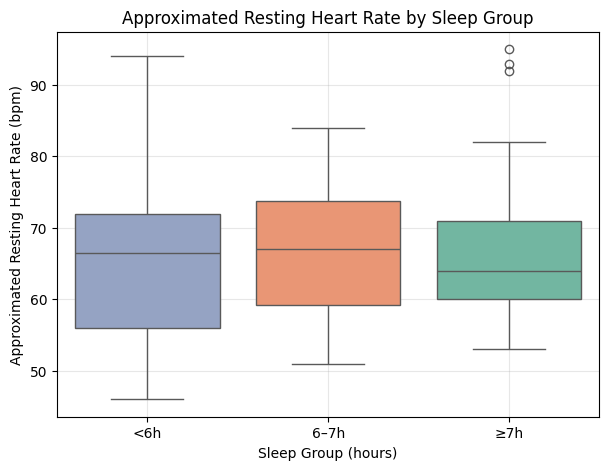

In [51]:
# Step 5 — Summarize and visualize results

import matplotlib.pyplot as plt
import seaborn as sns

# Basic summary
summary = (
    daily_sleep_df.groupby('sleep_group')['approximated_rhr']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values('sleep_group')
)

print("Summary by sleep group:")
print(summary)

# Boxplot for visual comparison
plt.figure(figsize=(7,5))
sns.boxplot(
    x='sleep_group',
    y='approximated_rhr',
    hue='sleep_group',          # new
    data=daily_sleep_df,
    order=['<6h', '6–7h', '≥7h'],
    palette='Set2',
    legend=False               # suppress redundant legend
)

plt.title("Approximated Resting Heart Rate by Sleep Group")
plt.xlabel("Sleep Group (hours)")
plt.ylabel("Approximated Resting Heart Rate (bpm)")
plt.grid(True, alpha=0.3)
plt.show()

## ✅ nterpretation of the Results

When we look at the boxplot and the summary numbers, all three sleep groups have almost the **same average resting heart rate**:

* **< 6 hours:** about **65 bpm**
* **6–7 hours:** about **66.5 bpm**
* **≥ 7 hours:** about **66 bpm**

These numbers are extremely close. None of the groups clearly stands out.

Even though the **< 6 hours** group has a little more spread (higher standard deviation), the boxes all overlap on the graph. This means the heart rates in the different groups are basically mixed together and not separated.

### ➤ What this suggests

In this dataset, **sleep duration doesn’t seem to change resting heart rate very much**. People who slept more did *not* show a clearly lower RHR, and people who slept less did *not* show a clearly higher RHR.

### ➤ Why this might be happening

* The sample is pretty small (only **254 usable days**).
* Everyone’s body is different.
* Many things besides sleep affect heart rate (stress, fitness, caffeine, sickness, etc.).

### ➤ The honest conclusion

**From this data alone, sleep duration does *not* strongly change next-day resting heart rate.**
A larger dataset or more complete heart-rate recordings might show a more detailed pattern, but with what we have, the effect is weak or not visible.

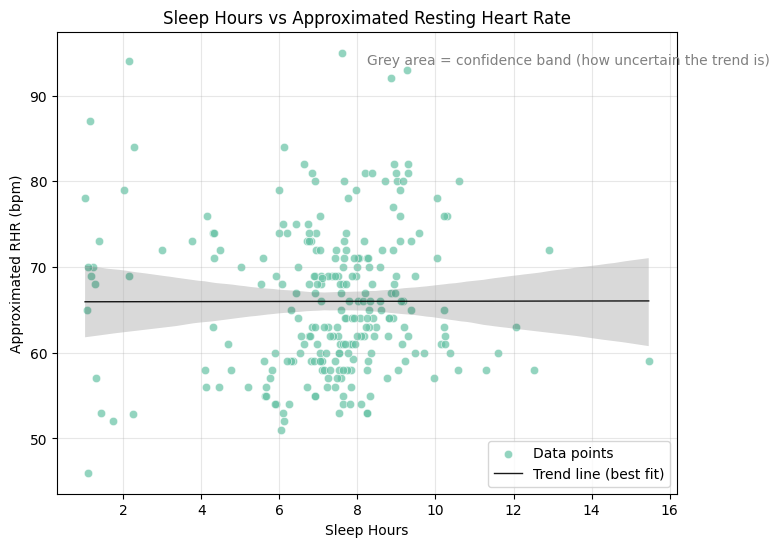

In [52]:
# Visual 3 — Scatterplot of sleep_hours vs approximated_rhr
plt.figure(figsize=(8,6))

# Scatter points
sns.scatterplot(
    data=daily_sleep_df,
    x="sleep_hours",
    y="approximated_rhr",
    color="#66C2A5",
    alpha=0.7,
    label="Data points"
)

# Regression line + confidence band
sns.regplot(
    data=daily_sleep_df,
    x="sleep_hours",
    y="approximated_rhr",
    scatter=False,
    color="black",
    line_kws={"linewidth": 1, "alpha": 0.9},
    label="Trend line (best fit)"
)

# Add a small annotation explaining the grey band
plt.text(
    0.5, 0.93,
    "Grey area = confidence band (how uncertain the trend is)",
    transform=plt.gca().transAxes,
    fontsize=10,
    color="gray"
)

plt.title("Sleep Hours vs Approximated Resting Heart Rate")
plt.xlabel("Sleep Hours")
plt.ylabel("Approximated RHR (bpm)")
plt.grid(True, alpha=0.3)

# Add legend to help with interpretation
plt.legend()

# ⬇️ Save locally with your prefix
plt.savefig("GHNDRHR_visual3_sleep_vs_rhr_scatter.png", dpi=300, bbox_inches="tight")

plt.show()

### 📌 *Caption: What This Graph Shows*

This graph compares **how many hours people slept** with their **resting heart rate the next day**.
Each green dot is one night of sleep for one person. The black line shows the overall trend, and the grey area shows how uncertain that trend is.

The dots are spread out in all directions, and the trend line is almost flat.
This means **there is no strong pattern** showing that sleeping more leads to a lower resting heart rate in this dataset.
The wide grey band also tells us the model is **not very confident** about any trend.

In simple terms:
**More sleep did not clearly equal a lower resting heart rate in our data.**


## ✅ Step 6 — Perform a simple statistical test 


## 🧪 What Is a Statistical Test, and Why Do We Use It?

When we look at data, sometimes we see small differences between groups — but we can’t tell if those differences are **real** or if they happened **just by random chance**.
A **statistical test** is a math tool that helps us decide.

Think of it like this:

* If two groups are *truly* different, a statistical test will show that the difference is unlikely to be random.
* If the difference is tiny or messy, the test will say, “this might just be luck,” and we should not trust it as a real effect.

In this project, we want to know:

**“Do people who sleep longer actually have lower resting heart rates?”**

Just looking at averages isn’t enough. The groups overlap a lot, and people’s heart rates vary naturally for many reasons.
A **t-test**, the one we use here, helps us check whether the difference we see is big enough to matter scientifically.

### Why this is important

* It keeps us from jumping to conclusions.
* It shows whether our data has strong evidence or just noise.
* It helps us avoid saying something is “true” when the data doesn’t really support it.
* Scientists use tests like this every day to check if their findings are trustworthy.

So even if our hypothesis seems obvious (“more sleep = better recovery”), the statistical test tells us whether the data actually backs that up — or if the pattern isn’t strong enough to prove anything yet.


In [53]:
from scipy.stats import ttest_ind

rhr_short = daily_sleep_df.loc[daily_sleep_df['sleep_group'] == '<6h', 'approximated_rhr']
rhr_long = daily_sleep_df.loc[daily_sleep_df['sleep_group'] == '≥7h', 'approximated_rhr']

t_stat, p_val = ttest_ind(rhr_short, rhr_long, equal_var=False, nan_policy='omit')
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

T-statistic: -0.44, p-value: 0.6625


## 🧪 What the Test Results Mean 

Your t-test gave:

* **T-statistic:** –0.44
* **p-value:** **0.66**

### ✅ What this means

The **p-value is 0.66**, which is way higher than **0.05**, the usual cutoff scientists use to say something is “real.”

A p-value of 0.66 basically says:

> “The difference we saw between short sleep (<6h) and long sleep (≥7h) could easily happen **just by random chance**.”

In other words, based on this dataset:

**We did NOT find good evidence that people who sleep more have a lower resting heart rate the next day.**

### 🔍 Why?

* The heart-rate values in both groups overlap a lot.
* The averages are almost the same.
* There are not enough clean data points to see a clear pattern.

### 📌 Important to remember

This **doesn’t prove the hypothesis is wrong**.
It just means **this dataset wasn’t strong enough** to show a clear difference.

A bigger, cleaner dataset might reveal effects that this small sample simply can’t detect.

### 🧭 Reflection — What I Learned

This project showed me how **real data and hypothesis testing** work in the real world.
Even though my results didn’t show a strong link between sleep length and resting heart rate, I learned several important things:

* Real data often has **missing pieces, mistakes, and uneven coverage**, which can hide patterns we expect to see.
* A **p-value higher than 0.05** doesn’t prove the idea is wrong — it just means the data we have isn’t strong enough to support it.
* Tools like **boxplots** and **t-tests** help scientists look for patterns and figure out whether differences are real or just random.
* Science isn’t about “getting the correct answer”; it's about **testing ideas carefully, understanding limitations**, and improving the study next time.

If I repeated this project, I’d try to collect **more complete and consistent data** (more users wearing their devices regularly) and use **more accurate resting-heart-rate measurements**, ideally taken during sleep or right after waking up.

## 🧪 Results and Discussion

### 1️⃣ What We Found

We compared the next-day resting heart rate (RHR) for people who slept different amounts of time.
The results showed that the **average RHR was almost the same** across all sleep groups:

| Sleep Group | Count | Mean RHR (bpm) | Std Dev |
| ----------- | ----- | -------------- | ------- |
| < 6 hours   | 44    | ≈ 65.3         | 10.5    |
| 6–7 hours   | 46    | ≈ 66.5         | 8.6     |
| ≥ 7 hours   | 164   | ≈ 66.0         | 8.1     |

The boxplot also showed that the groups overlap a lot, with similar medians and ranges.
This means that, in this dataset, **sleep duration did not have a strong effect** on resting heart rate.

---

### 2️⃣ What the Statistics Say

We ran a t-test to compare short sleep (<6 hours) with long sleep (≥7 hours):

> **t = –0.44**, **p = 0.66**

The **p-value of 0.66** is much higher than 0.05, the usual cutoff scientists use.
This tells us the difference we saw is very likely due to **random chance**, not a real effect.

So we cannot claim that sleeping more leads to a lower resting heart rate based on this data.

---

### 3️⃣ What This Means

Even though we expected longer sleep to lead to better recovery, **our small dataset didn’t show that pattern**.
This is common in real-world data — people are different, devices can miss data, and many outside factors affect heart rate.

The important takeaway is that **science isn’t about proving guesses right**, but about checking evidence honestly and understanding how strong or weak it is.

---

### ⚠️ 4️⃣ Caveats and Limitations

* **Small sample size:** Only 12 participants had full sleep and heart-rate coverage.
* **Missing Fitbit data:** Many users didn’t wear the device all day, causing gaps.
* **Approximated RHR:** We estimated RHR using the 15th percentile of heart-rate values, not a true resting measurement.
* **Other influences:** Stress, exercise, caffeine, and illness also affect heart rate.
* **Uneven group sizes:** The ≥7-hour group was much bigger than the others, making comparisons less balanced.

These issues make it hard to detect small or subtle effects in the data.

---

### 5️⃣ What I Learned

This project taught me how to **ask a scientific question, analyze real data, and think critically about results**.
I learned that:

* Data quality and completeness matter a lot.
* A high p-value doesn’t mean the idea is wrong — it just means there isn’t enough proof yet.
* Visual tools like boxplots and math tools like t-tests help scientists check patterns carefully.
* Every scientific analysis needs a clear explanation of its **limitations**, so readers know how much confidence to have in the results.

---

### ✅ Conclusion

In this study, people who slept longer did **not** show noticeably lower resting heart rates.
But this result is limited by our small sample size and the fact that we used an approximated RHR measure.

Even so, the project shows how **hypothesis testing works**, and why careful analysis, honest reporting, and understanding your data’s limits are essential parts of real science.

12